# Visualizations  

Using the hyperparamters from the [Modeling Notebook](https://github.com/irwin-lam/PumpItUp/blob/main/Modeling-v2.ipynb) and the data from [EDA notebook](https://github.com/irwin-lam/PumpItUp/blob/main/EDA.ipynb). 

<span style = 'color:green; font-size:13pt'>**Note:**</span> Clicking on anything in the table of content will send you to section. Clicking on the headers will send you back to the Table of Contents
<hr style="border:2px solid magenta">

## Table of Contents: <a id ="title"><a>
- [Imports](#imports)
- [Opening Data](#opening)
- [Pipelines](#pipeline)
- [Helper Functions](#functions)
- [Models](#models)
- [ROC Curves](#rocs)
- [Histograms](#histograms)
- [Precision vs Recall](#pr)
- [Grid Search CV](#gs)
- [Summary](#summary)
- [Exporting to CSVs](#exports)
- [Conclusions](#conclusions)

### [Imports](#title) <a id ="imports"><a>
<hr style="border:2px solid magenta">

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import ast
from matplotlib import pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, \
                                    KFold,cross_validate, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, \
                            plot_confusion_matrix, roc_curve,auc, \
                            precision_recall_curve, average_precision_score
from sklearn.compose import ColumnTransformer, make_column_selector as selector

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline
%matplotlib inline

### [Opening Data](#title)  <a id ='opening'></a>
<hr style="border:2px solid magenta">

In [2]:
model = pd.read_csv('./Data/Model1.csv')
df = pd.read_csv('./Data/TrainCleaned1.csv')
lg_cv = pd.read_csv('./Data/GridSearch1cv_results.csv')
smote_cv = pd.read_csv('./Data/SmoteGridSearch1cv_results.csv')

In [3]:
x = df.drop('status_group', axis =1)
y = df.status_group

xtrain,xtest, ytrain, ytest = train_test_split(x,y,random_state=42)

### [Pipelines](#title)  <a id ='pipeline'></a>  
<hr style="border:2px solid magenta">

In [4]:
subpipenum = Pipeline([
    ('num_impute',SimpleImputer(add_indicator=True)),
    ('ss', StandardScaler())
])

subpipecat = Pipeline([
    ('cat_impute', SimpleImputer(strategy='most_frequent', add_indicator=True)),
    ('ohe', OneHotEncoder(sparse=True, handle_unknown='ignore'))
])

ct = ColumnTransformer(transformers = [
    ('subpipe_num',subpipenum, selector(dtype_include=np.number)),
    ('subpipe_cat', subpipecat, selector(dtype_include=object))
], remainder='passthrough', n_jobs = -1)



### [Helper Functions](#title) <a id ='functions'></a>  
<hr style="border:2px solid magenta">

<span style = 'color:green; font-size:13pt'>roc_curve_ovr</span><a id = 'func4'></a>  
**parameters**  
><span style = 'color:blue'>estimator</span> &rarr; Model  
><span style = 'color:blue'>modelname</span> &rarr; name of the model  
><span style = 'color:blue'>x</span> &rarr; x values  
><span style = 'color:blue'>y</span> &rarr; y values
***
**returns** print graph  
***
**how it works**  
* creates a y_pred_prob to store the probabalities
* loops thru the target class in y
* creates a binary y where the value is 1 if the y is equal to the class name else 0
* fpr, tpr from roc_curve function
* roc_auc from auc function
* plot it
* make graph look pretty and save it

In [5]:
def roc_curve_ovr(estimator, modelname, x, y):

    y_pred_prob = cross_val_predict(estimator, x, y, method='predict_proba', n_jobs = -1)
    for idx, label in enumerate(np.unique(ytrain)):

        y_binary = (y == label).astype(int)
        fpr, tpr, _ = roc_curve(y_binary, y_pred_prob[:, idx])

        roc_auc = auc(fpr, tpr)

        plt.plot(fpr,tpr, label= f'{label} (AUC = {roc_auc:.4f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line for reference
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(f'{modelname} ROC Curves for Each Class')
    plt.legend(loc='lower right')
    plt.savefig(f'./Figures/roc_{modelname}.png', facecolor='white', transparent=False, dpi=175)
    plt.show()

<hr style="border:2px solid orange">  

<span style = 'color:green; font-size:13pt'>cv_summary</span><a id = 'func4'></a>  
**parameters**  
><span style = 'color:blue'>estimator</span> &rarr; Model  
><span style = 'color:blue'>modelname</span> &rarr; name of the model  
><span style = 'color:blue'>x</span> &rarr; x values  
><span style = 'color:blue'>y</span> &rarr; y values
***
**returns** print cv graph  
***
**how it works**  
* creates ypred from model.predict()
* get the counts and value from ypred to a dataframe 
* ytrue is the value_counts
* combine with ytrue to make a consolidated dataframe  
* graph it and add annotation to the top of each bar
* save it as png



In [6]:
def plot_histograms(estimator, modelname, x, y):
    ypred = estimator.predict(x)
    value, counts = np.unique(ypred, return_counts=True)
    ypredcounts = pd.DataFrame(counts.T)
    ypredcounts.index = value
    ypred = ypredcounts.reset_index()
    
    ytrue = y.value_counts().to_frame().reset_index()
    ytrue = ytrue.merge(ypred, on ='index')
    ytrue = ytrue.rename(columns = {0: 'ypred', 'index': 'well condition', 'status_group': 'ytrue'})
    ytrue =ytrue.melt(id_vars = ['well condition'],value_vars=['ytrue', 'ypred'])
    
    graph = sns.catplot(data=ytrue, kind='bar', x='well condition', y='value', hue ='variable');
    
    ax = graph.ax
    
    for patch in ax.patches:
        ax.annotate(f'{patch.get_height():.0f}', (patch.get_x() + patch.get_width()/2., patch.get_height()), ha='center', va='bottom')
    
    plt.title(f'{modelname} Model')
    plt.xlabel('Well Condition')
    plt.ylabel('Counts')
    plt.savefig(f'./Figures/hist_{modelname}.png', facecolor='white', transparent=False, dpi=175)

<hr style="border:2px solid orange">  

<span style = 'color:green; font-size:13pt'>cv_summary</span><a id = 'func4'></a>  
**parameters**  
><span style = 'color:blue'>estimator</span> &rarr; Model  
><span style = 'color:blue'>modelname</span> &rarr; name of the model  
><span style = 'color:blue'>x</span> &rarr; x values  
><span style = 'color:blue'>y</span> &rarr; y values
***
**returns** print cv graph  
***
**how it works**  
* empty dictionary curve
* make a subplot
* y_pred_prob from cross_val_predict
* loop through the classes
* ybinary where 1 is the value is equal to the class else 0
* precision, recall from precision_recall_curve
* get the average precision score  
* plot it  
* delete the last subplot since we have 3 graphs not 4  
* save it

In [7]:
def precision_vs_recall(estimator, modelname, x, y):
    curve = {}
    fig, ax = plt.subplots(2,2, figsize = (12,8))
    y_pred_prob = cross_val_predict(estimator, x, y, method='predict_proba', n_jobs = -1)
    
    for idx, label in enumerate(np.unique(y)):
        y_binary = (y == label).astype(int)
        precision, recall, _ = precision_recall_curve(y_binary, y_pred_prob[:,idx])
        average_precision = average_precision_score(y_binary, y_pred_prob[:,idx])
        curve[label] = (precision, recall, average_precision)
        ax[idx//2 , idx % 2].step(recall, precision, color='b', alpha=0.2, where='post')
        ax[idx//2 , idx % 2].fill_between(recall, precision, alpha=0.2, color='b')
        ax[idx//2 , idx % 2].set_xlabel('Recall')
        ax[idx//2 , idx % 2].set_ylabel('Precision')
        ax[idx//2 , idx % 2].set_ylim([0.0, 1.05])
        ax[idx//2 , idx % 2].set_xlim([0.0, 1.0])
        ax[idx//2 , idx % 2].set_title(f'{label} (AP={average_precision:.4f})')
        
    fig.suptitle(f'{modelname}')
    plt.delaxes(ax[1,1])
    plt.tight_layout()
    plt.savefig(f'./Figures/pr_{modelname}.png', facecolor='white', transparent=False, dpi=175)
    plt.show()

### [Creating the models with the hyper parameters](#title) <a id ='models'></a>  
<hr style="border:2px solid magenta">  

Setting variables equal to the best hyperparamters to use in the models.

In [8]:
lgrbestparam = model.params[2]
lgrbestparam = ast.literal_eval(lgrbestparam)

smbestparam = model.params[3]
smbestparam = ast.literal_eval(smbestparam)

smlbestparam = model.params[4]
smlbestparam = ast.literal_eval(smlbestparam)

In [9]:
%%time
lgr = Pipeline([
    ('ct', ct),
    ('lg', LogisticRegression(random_state=42, n_jobs=-1))
])


lgr.fit(xtrain, ytrain)

Wall time: 9.45 s


Pipeline(steps=[('ct',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(add_indicator=True)),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000024308D5A550>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='most_frequent')),


In [10]:
%%time
best_lgr = Pipeline([
    ('ct', ct),
    ('lg', LogisticRegression(random_state = 42, 
                              C = lgrbestparam['lg__C'], 
                              max_iter = lgrbestparam['lg__max_iter'], 
                              solver = lgrbestparam['lg__solver'],
                              tol = lgrbestparam['lg__tol'],
                             n_jobs=-1))
])


best_lgr.fit(xtrain,ytrain)

Wall time: 24.9 s


Pipeline(steps=[('ct',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(add_indicator=True)),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000024308D5A550>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='most_frequent')),


In [11]:
%%time
imbpipe = ImPipeline([
    ('ct', ct),
    ('sm', SMOTE(random_state = 42, n_jobs =-1)),
    ('gs_best', LogisticRegression(random_state = 42, 
                                   C = lgrbestparam['lg__C'], 
                                   max_iter = lgrbestparam['lg__max_iter'], 
                                   solver = lgrbestparam['lg__solver'],
                                   tol = lgrbestparam['lg__tol'],
                                   n_jobs=-1))
])

imbpipe.fit(xtrain, ytrain)

Wall time: 47.8 s


Pipeline(steps=[('ct',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(add_indicator=True)),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000024308D5A550>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='most_frequent')),


In [12]:
%%time
imbpipesm = ImPipeline([
    ('ct', ct),
    ('sm', SMOTE(k_neighbors = smlbestparam['sm__k_neighbors'],
                 sampling_strategy= smlbestparam['sm__sampling_strategy'],
                 random_state = 42, n_jobs =-1)),
    ('gs_best', LogisticRegression(random_state = 42, 
                                   C = lgrbestparam['lg__C'], 
                                   max_iter = lgrbestparam['lg__max_iter'], 
                                   solver = lgrbestparam['lg__solver'],
                                   tol = lgrbestparam['lg__tol'],
                                   n_jobs=-1))
])

imbpipesm.fit(xtrain,ytrain)

Wall time: 35.1 s


Pipeline(steps=[('ct',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(add_indicator=True)),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000024308D5A550>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='most_frequent')),


Fitting all these models took about 4 minutes.

### [ROC Curves](#title) <a id ='rocs'></a>  
<hr style="border:2px solid magenta">  

Making the graphs for each model

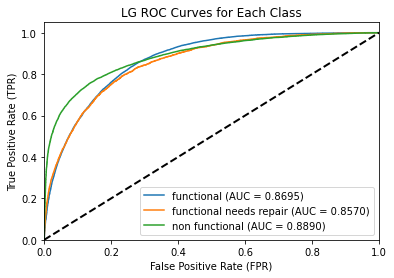

In [13]:
roc_curve_ovr(lgr, 'LG',xtrain, ytrain)

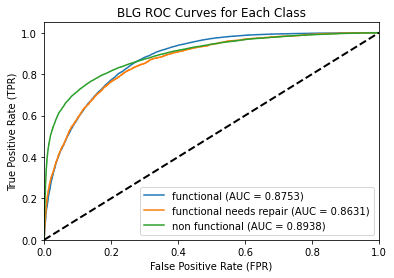

In [14]:
roc_curve_ovr(best_lgr, 'BLG', xtrain, ytrain)

This improves slightly compared to the base logistic regression

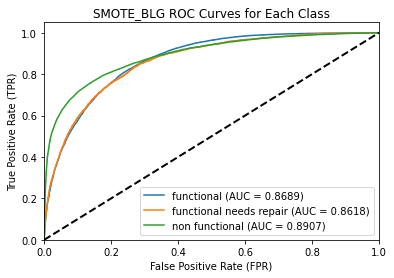

In [15]:
roc_curve_ovr(imbpipe, 'SMOTE_BLG', xtrain, ytrain)

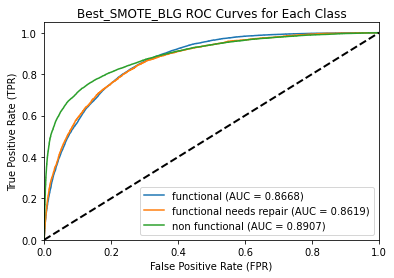

In [16]:
roc_curve_ovr(imbpipesm, 'Best_SMOTE_BLG', xtrain, ytrain)

The tuned smote turns out to have performed worse than the baseline smote. 

### [Histograms](#title) <a id ='histograms'></a>  
<hr style="border:2px solid magenta">

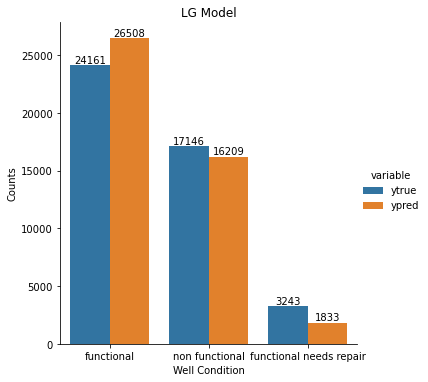

In [17]:
plot_histograms(lgr, 'LG',xtrain, ytrain)

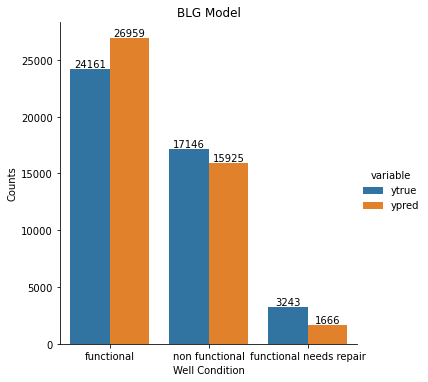

In [18]:
plot_histograms(best_lgr, 'BLG', xtrain, ytrain)


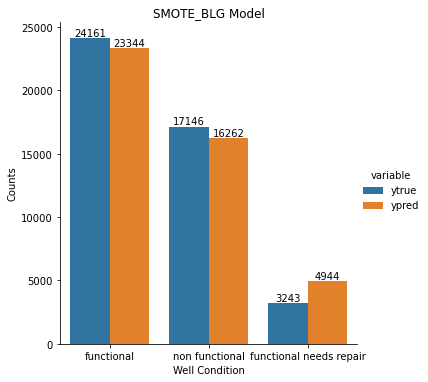

In [19]:
plot_histograms(imbpipe, 'SMOTE_BLG', xtrain, ytrain)

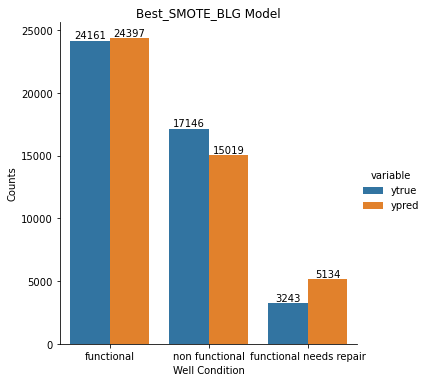

In [20]:
plot_histograms(imbpipesm, 'Best_SMOTE_BLG', xtrain, ytrain)


### [Precision Vs Recall](#title) <a id ='pr'></a>  
<hr style="border:2px solid magenta">

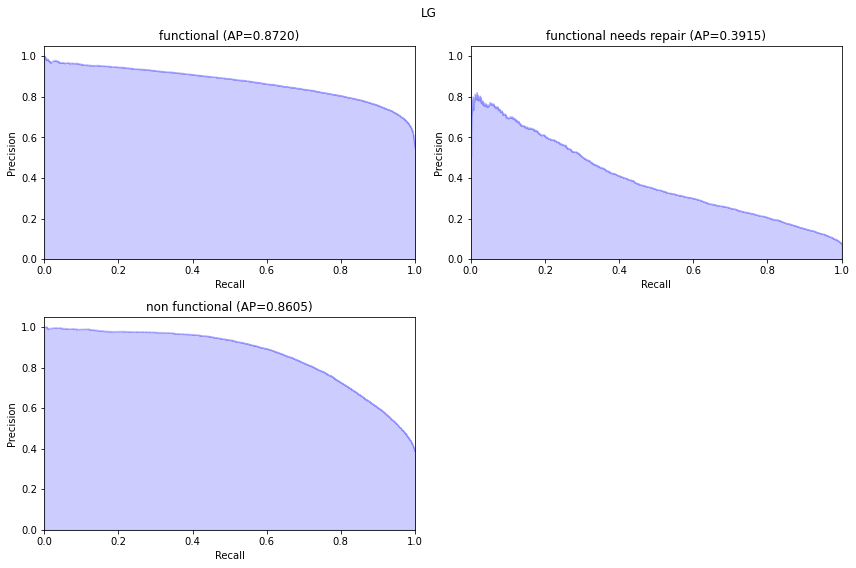

In [21]:
precision_vs_recall(lgr,'LG',xtrain,ytrain)

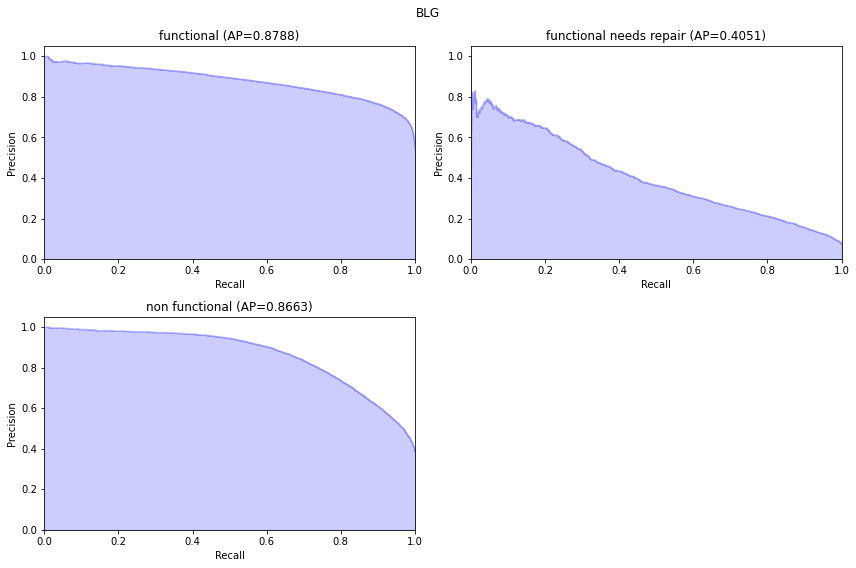

In [22]:
precision_vs_recall(best_lgr, 'BLG',xtrain,ytrain)

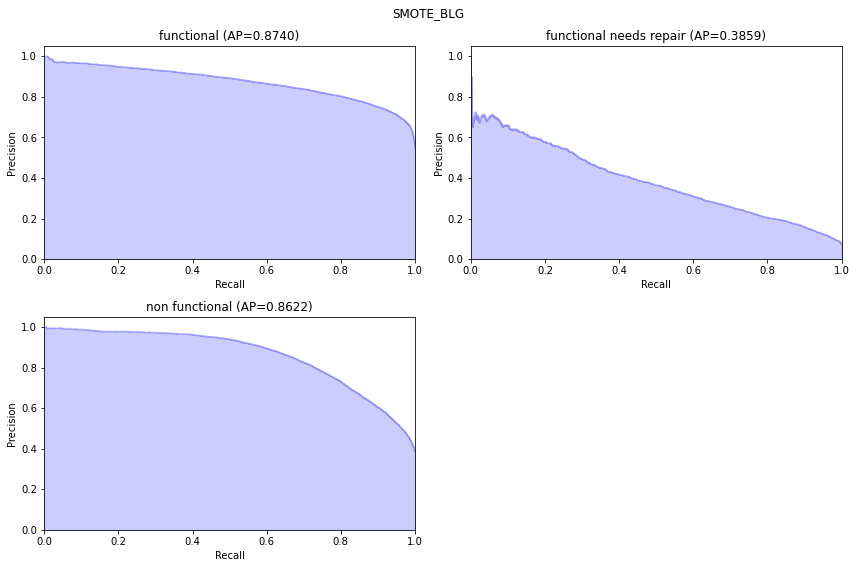

In [23]:
precision_vs_recall(imbpipe, 'SMOTE_BLG',xtrain,ytrain)

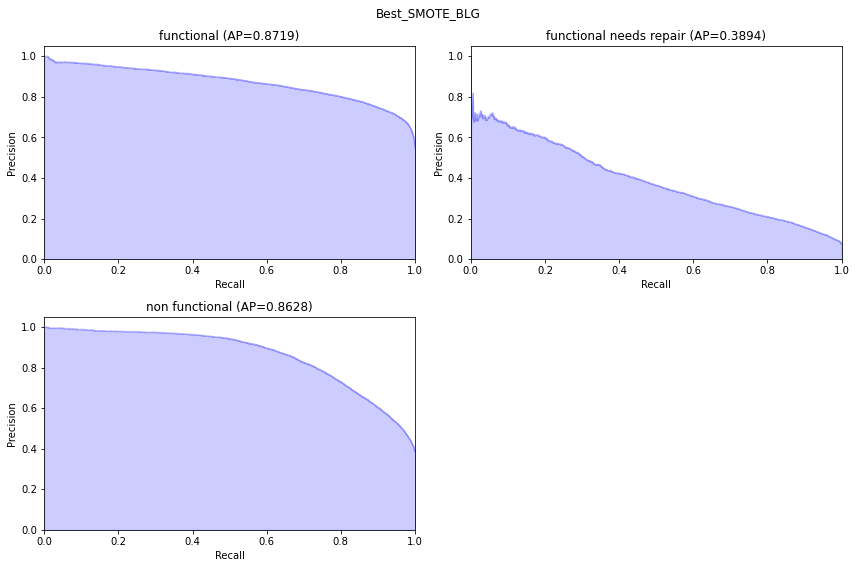

In [24]:
precision_vs_recall(imbpipesm,'Best_SMOTE_BLG',xtrain,ytrain)

In [25]:
model['delta'] = model['train_score'] - model['test_score']

In [26]:
model

,Model,train_score,test_score,log_loss,params,delta
0,Dummy,0.447385,0.437306,19.120760,None,0.010079
1,LogReg,0.861347,0.775286,0.570089,None,0.086061
2,Best LogReg,0.877800,0.781818,0.547148,"{'lg__C': 0.5, 'lg__class_weight': {'functiona...",0.095982
3,Smote with Best LogReg,0.889630,0.752929,0.595275,"{'lg__C': 0.5, 'lg__class_weight': {'functiona...",0.136700
4,Best Smote + LogReg,0.879596,0.753266,0.596776,"{'sm__k_neighbors': 15, 'sm__sampling_strategy...",0.126330


### [Grid Search Cv](#title) <a id ="gs"><a>
<hr style="border:2px solid magenta">

In [27]:
lg_cv.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lg__C,param_lg__class_weight,param_lg__max_iter,param_lg__solver,param_lg__tol,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,24.474629,0.867821,0.338752,0.125597,0.1,"{'functional': 1, 'non functional': 1, 'functi...",250,lbfgs,0.0001,"{'lg__C': 0.1, 'lg__class_weight': {'functiona...",0.776207,0.769585,0.764759,0.771044,0.767228,0.769764,0.003864,381
1,25.252330,0.977403,0.202172,0.050383,0.1,"{'functional': 1, 'non functional': 1, 'functi...",250,lbfgs,0.0050,"{'lg__C': 0.1, 'lg__class_weight': {'functiona...",0.776207,0.769585,0.764759,0.771044,0.767228,0.769764,0.003864,381
2,24.637845,1.310236,0.358583,0.059063,0.1,"{'functional': 1, 'non functional': 1, 'functi...",250,lbfgs,0.0010,"{'lg__C': 0.1, 'lg__class_weight': {'functiona...",0.776207,0.769585,0.764759,0.771044,0.767228,0.769764,0.003864,381
3,25.401778,1.340414,0.323282,0.149985,0.1,"{'functional': 1, 'non functional': 1, 'functi...",250,lbfgs,0.0100,"{'lg__C': 0.1, 'lg__class_weight': {'functiona...",0.776207,0.769585,0.764759,0.771044,0.767228,0.769764,0.003864,381
4,22.343867,2.119269,0.294466,0.137948,0.1,"{'functional': 1, 'non functional': 1, 'functi...",250,lbfgs,0.1000,"{'lg__C': 0.1, 'lg__class_weight': {'functiona...",0.776207,0.769585,0.764759,0.771044,0.767228,0.769764,0.003864,381


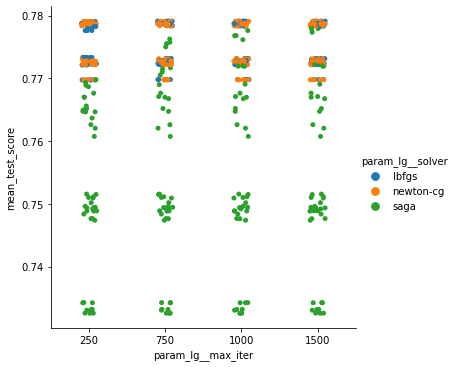

In [28]:
sns.catplot(data=lg_cv, x='param_lg__max_iter', y='mean_test_score', hue ='param_lg__solver');

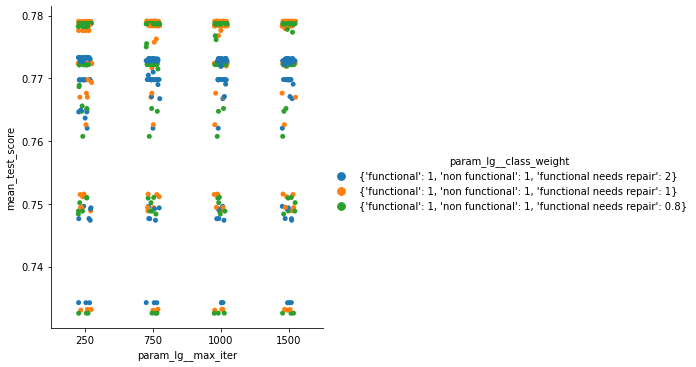

In [29]:
sns.catplot(data=lg_cv, x='param_lg__max_iter', y='mean_test_score', hue ='param_lg__class_weight');

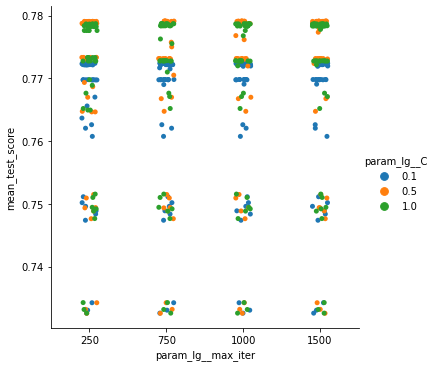

In [30]:
sns.catplot(data=lg_cv, x='param_lg__max_iter', y='mean_test_score', hue ='param_lg__C');

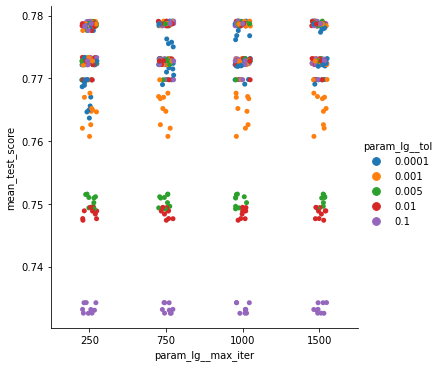

In [31]:
sns.catplot(data=lg_cv, x='param_lg__max_iter', y='mean_test_score', hue ='param_lg__tol');